<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-23_23_26_45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [ ]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [ ]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [ ]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [ ]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [ ]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [ ]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [ ]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 25

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [ ]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = SGD(model.parameters())

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [ ]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.3033, Loss:  0.0086
Epoch	2	Acc:  0.6117, Loss:  0.0078
Epoch	3	Acc:  0.7069, Loss:  0.0071
Epoch	4	Acc:  0.7434, Loss:  0.0065
Epoch	5	Acc:  0.7629, Loss:  0.0060
Epoch	6	Acc:  0.7761, Loss:  0.0056
Epoch	7	Acc:  0.7854, Loss:  0.0052
Epoch	8	Acc:  0.7940, Loss:  0.0049
Epoch	9	Acc:  0.8007, Loss:  0.0047
Epoch	10	Acc:  0.8066, Loss:  0.0045
Task 0 Acc:  0.8208, Loss:  0.0044
Task 1 Acc:  0.1169, Loss:  0.0095

Task 1 Start!
Epoch	1	Acc:  0.1289, Loss:  0.0091
Epoch	2	Acc:  0.1479, Loss:  0.0089
Epoch	3	Acc:  0.1644, Loss:  0.0088
Epoch	4	Acc:  0.1794, Loss:  0.0087
Epoch	5	Acc:  0.1934, Loss:  0.0086
Epoch	6	Acc:  0.2067, Loss:  0.0086
Epoch	7	Acc:  0.2201, Loss:  0.0085
Epoch	8	Acc:  0.2306, Loss:  0.0085
Epoch	9	Acc:  0.2404, Loss:  0.0084
Epoch	10	Acc:  0.2500, Loss:  0.0084
Task 0 Acc:  0.8143, Loss:  0.0044
Task 1 Acc:  0.2490, Loss:  0.0083



 - Task 0

Accuracy 0.8143
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.82      0.95      0.88       980
     1 - one       0.88      0.93      0.91      1135
     2 - two       0.77      0.81      0.79      1032
   3 - three       0.69      0.88      0.78      1010
    4 - four       0.86      0.78      0.82       982
    5 - five       0.94      0.46      0.61       892
     6 - six       0.85      0.85      0.85       958
   7 - seven       0.91      0.85      0.88      1028
   8 - eight       0.75      0.77      0.76       974
    9 - nine       0.77      0.80      0.79      1009

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



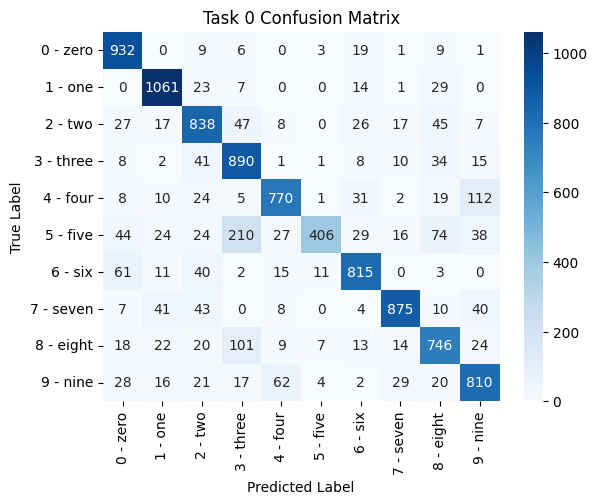

In [ ]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.249
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.36      0.74      0.49       980
     1 - one       0.00      0.00      0.00      1135
     2 - two       0.20      0.19      0.20      1032
   3 - three       0.14      0.10      0.12      1010
    4 - four       0.13      0.17      0.15       982
    5 - five       0.04      0.01      0.02       892
     6 - six       0.32      0.27      0.30       958
   7 - seven       0.27      0.39      0.32      1028
   8 - eight       0.41      0.40      0.40       974
    9 - nine       0.22      0.23      0.23      1009

    accuracy                           0.25     10000
   macro avg       0.21      0.25      0.22     10000
weighted avg       0.21      0.25      0.22     10000



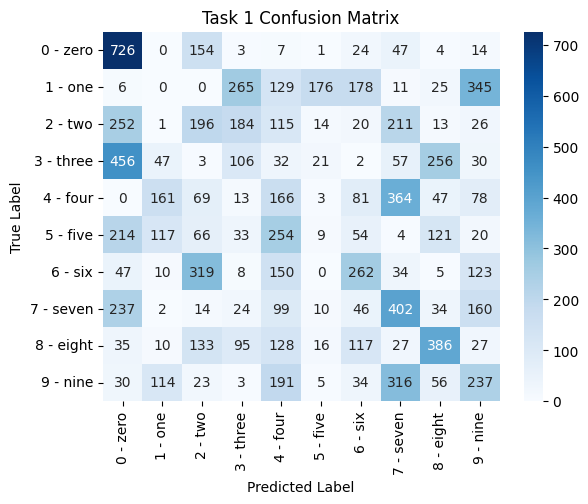

In [ ]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 9.18121 and it's parameter diff is 0.00005
Min Parameter diff is 0.06798 and it's fisher is 0.01032
fisher > parameter diff: 498
fisher <= parameter diff: 286


<Figure size 640x480 with 0 Axes>

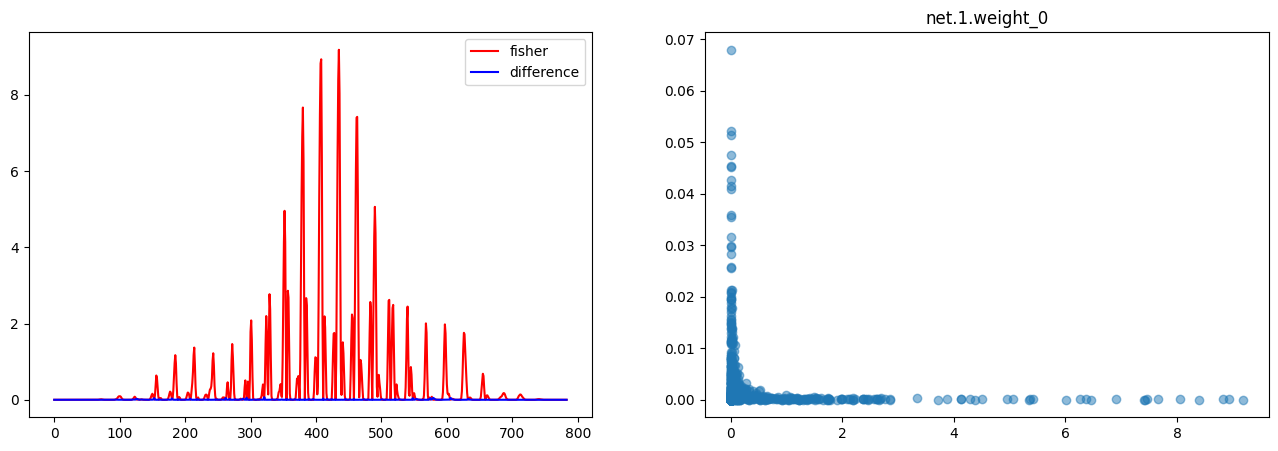

Max fisher is 19.04135 and it's parameter diff is 0.00004
Min Parameter diff is 0.05785 and it's fisher is 0.00049
fisher > parameter diff: 509
fisher <= parameter diff: 275


<Figure size 640x480 with 0 Axes>

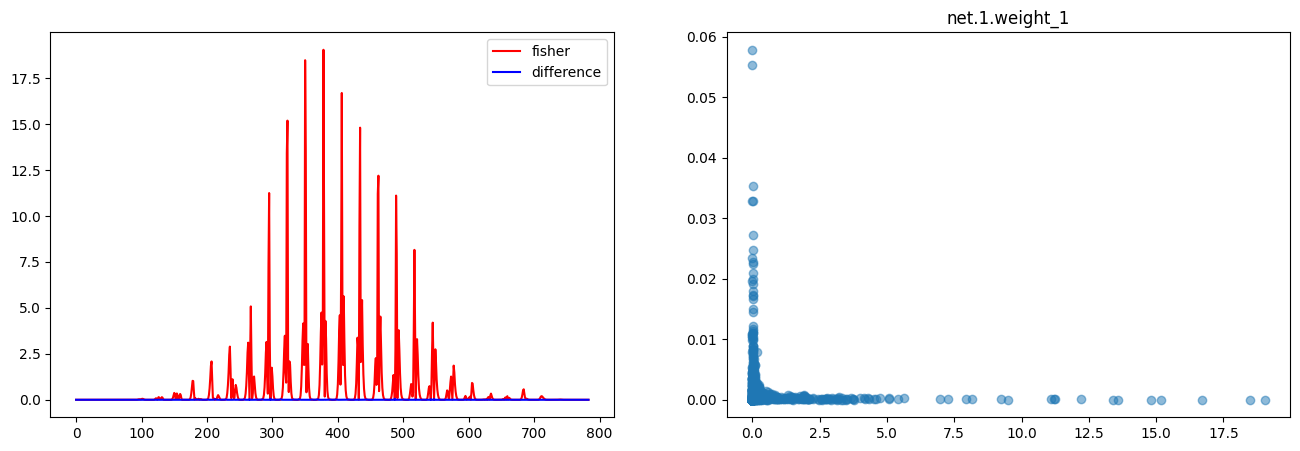

Max fisher is 6.67729 and it's parameter diff is 0.00000
Min Parameter diff is 0.06095 and it's fisher is 0.00123
fisher > parameter diff: 503
fisher <= parameter diff: 281


<Figure size 640x480 with 0 Axes>

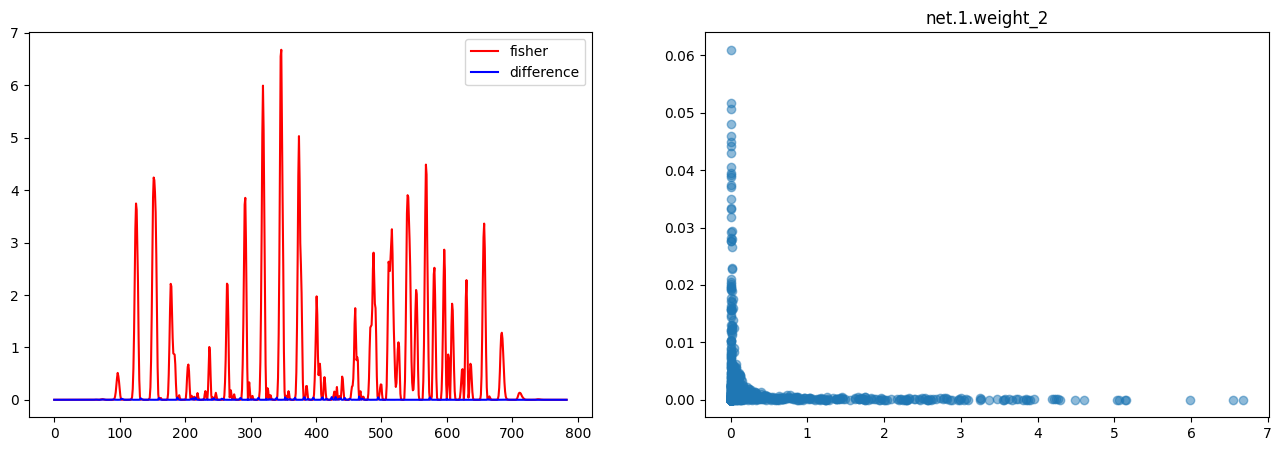

Max fisher is 5.78365 and it's parameter diff is 0.00009
Min Parameter diff is 0.06558 and it's fisher is 0.00210
fisher > parameter diff: 514
fisher <= parameter diff: 270


<Figure size 640x480 with 0 Axes>

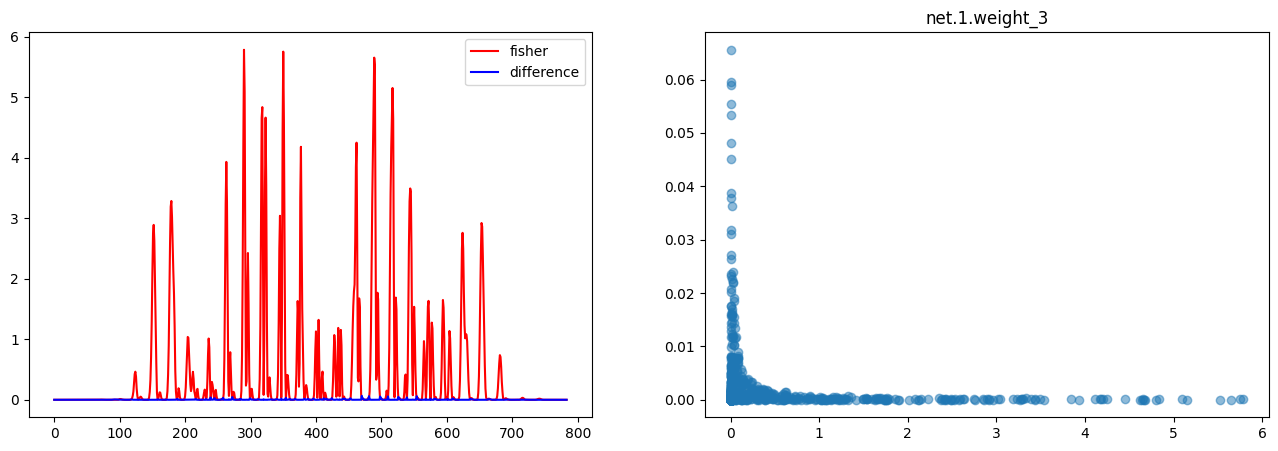

Max fisher is 9.82187 and it's parameter diff is 0.00002
Min Parameter diff is 0.07462 and it's fisher is 0.00045
fisher > parameter diff: 477
fisher <= parameter diff: 307


<Figure size 640x480 with 0 Axes>

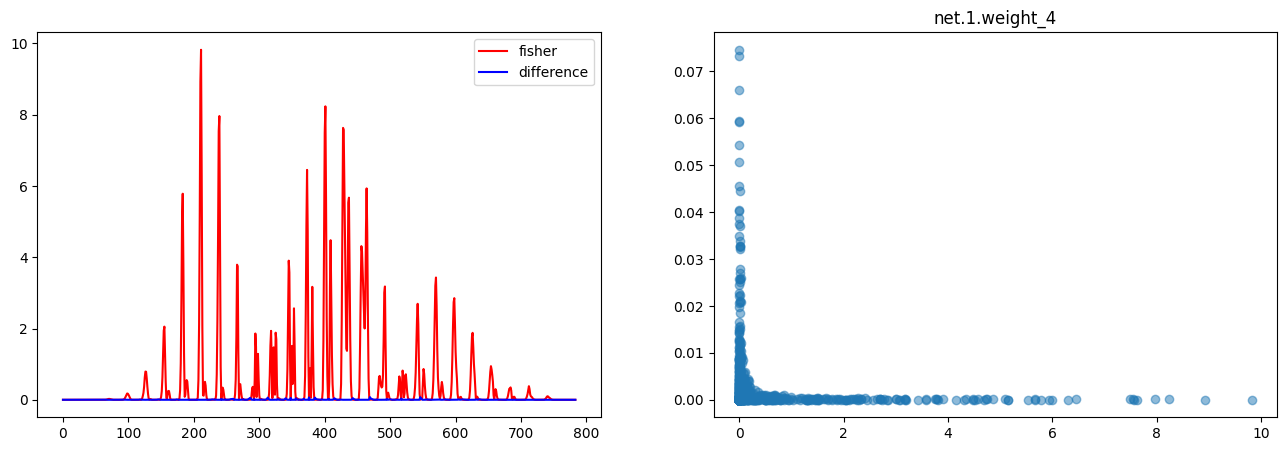

Max fisher is 8.30641 and it's parameter diff is 0.00003
Min Parameter diff is 0.03984 and it's fisher is 0.00228
fisher > parameter diff: 492
fisher <= parameter diff: 292


<Figure size 640x480 with 0 Axes>

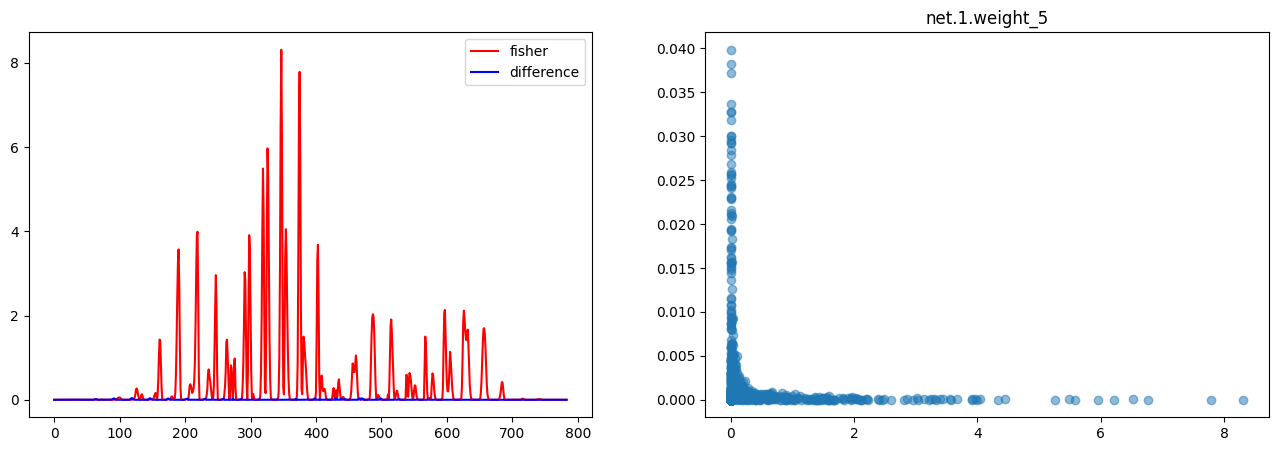

Max fisher is 9.31052 and it's parameter diff is 0.00003
Min Parameter diff is 0.07163 and it's fisher is 0.00225
fisher > parameter diff: 521
fisher <= parameter diff: 263


<Figure size 640x480 with 0 Axes>

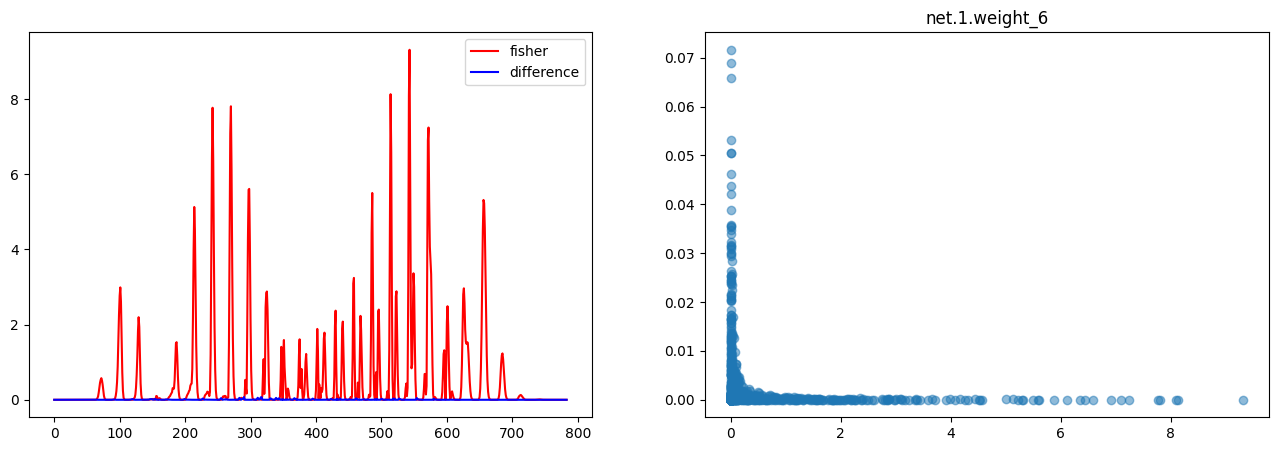

Max fisher is 8.43127 and it's parameter diff is 0.00006
Min Parameter diff is 0.07733 and it's fisher is 0.00276
fisher > parameter diff: 516
fisher <= parameter diff: 268


<Figure size 640x480 with 0 Axes>

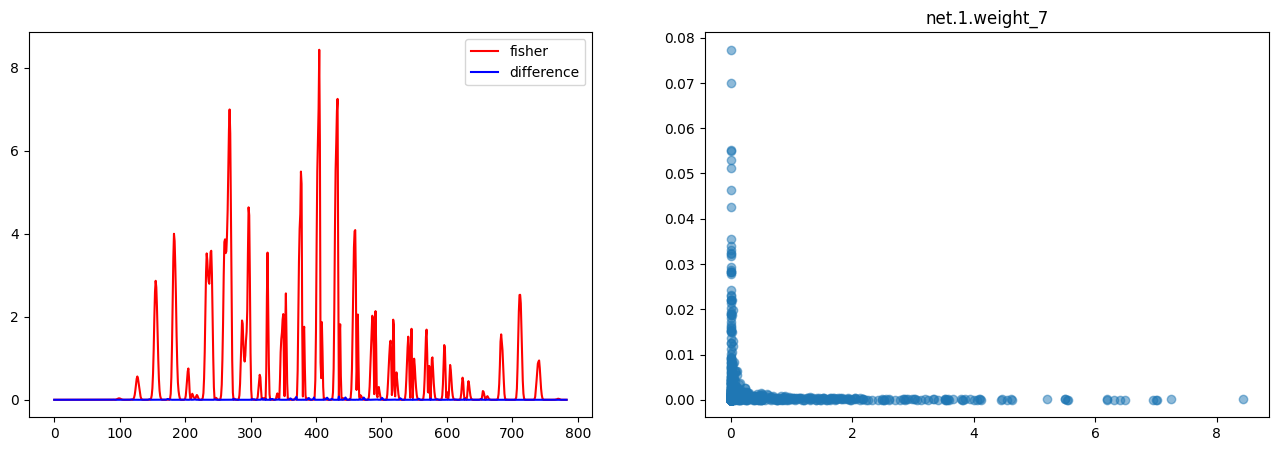

Max fisher is 4.85316 and it's parameter diff is 0.00001
Min Parameter diff is 0.04850 and it's fisher is 0.00014
fisher > parameter diff: 494
fisher <= parameter diff: 290


<Figure size 640x480 with 0 Axes>

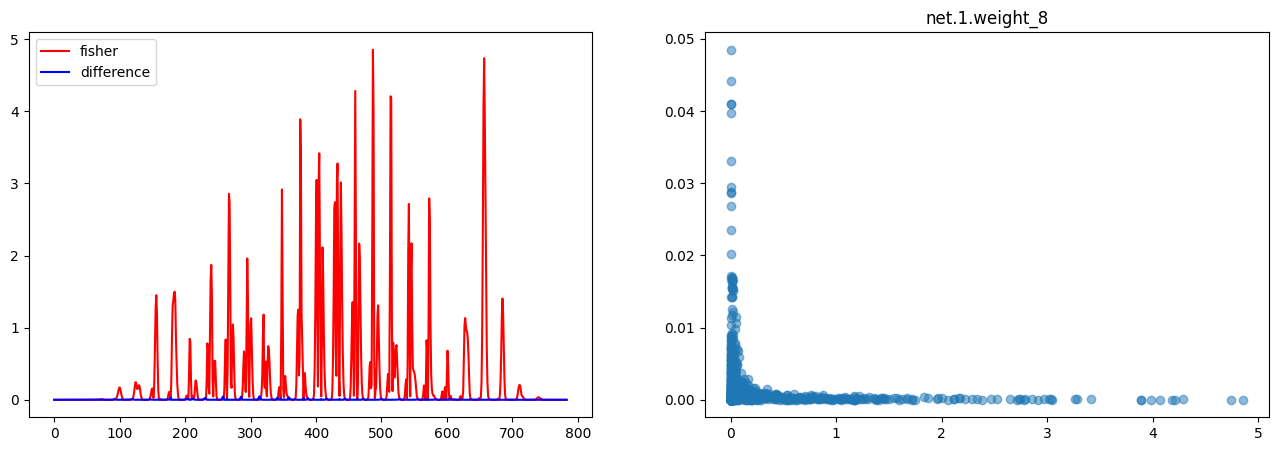

Max fisher is 8.03564 and it's parameter diff is 0.00002
Min Parameter diff is 0.03725 and it's fisher is 0.00067
fisher > parameter diff: 510
fisher <= parameter diff: 274


<Figure size 640x480 with 0 Axes>

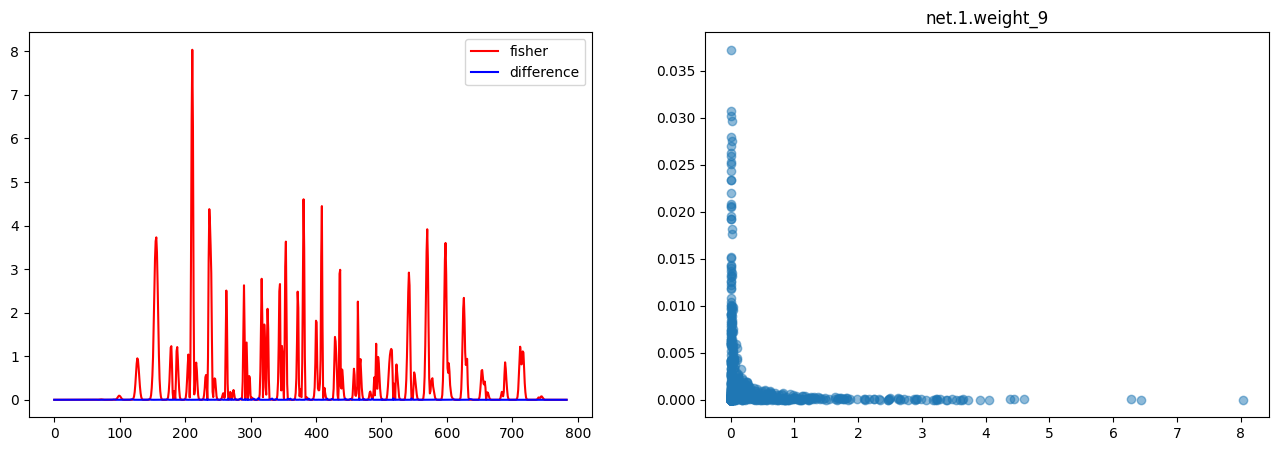


net.1.bias
torch.Size([10])
Max fisher is 3.93749 and it's parameter diff is 0.00023
Min Parameter diff is 0.00613 and it's fisher is 0.03792
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

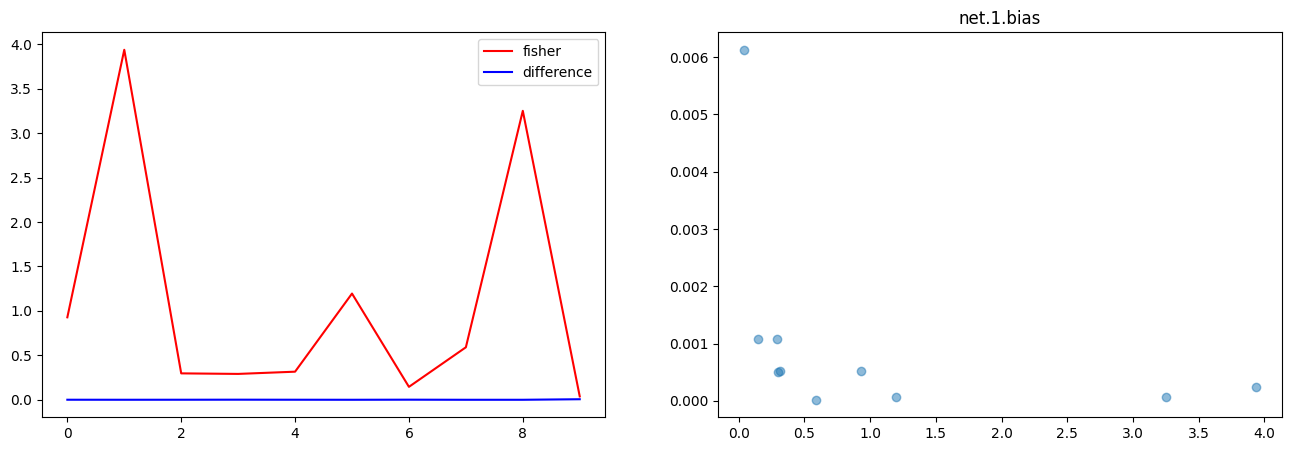

In [ ]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [ ]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-23_23_26_45
